<a href="https://colab.research.google.com/github/sungjindo/cyclegan/blob/main/standard_instance_3enco%EC%84%B1%EC%A7%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 기본 작업

In [ ]:
# 구글 드라이브 마운트 및 경로 설정

from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive/MyDrive/python/pokemon

[Errno 2] No such file or directory: 'gdrive/MyDrive/python/pokemon'
/content/gdrive/MyDrive/python/pokemon


 ## 1. 필요 라이브러리 임포트

In [ ]:
# 기본 라이브러리
import os
import numpy as np
import math
import itertools
import glob
import random
import sys

# 데이터 처리 관련 라이브러리
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# 학습 관련 라이브러리
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.utils import save_image, make_grid
from torchvision import datasets
from torch.autograd import Variable
import datetime
import time

## 2. 클래스 및 함수 정의

#### 1. DataSet

In [ ]:
# 흑백사진 RGB 변환 함수

def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [ ]:
# Train / Test 모드에 따라 DataSet 불러오는 class 정의

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        if mode=="train":
            self.files_A = sorted(glob.glob(os.path.join(root, "trainA") + "/*.*"))
            self.files_B = sorted(glob.glob(os.path.join(root, "trainB") + "/*.*"))
        else:
            self.files_A = sorted(glob.glob(os.path.join(root, "testA") + "/*.*"))
            self.files_B = sorted(glob.glob(os.path.join(root, "testB") + "/*.*"))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

#### 2. Generator & Discriminator

In [ ]:
# 가중치 관련 함수 정의

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
# Generator 내 ResidualBlock 관련 class 정의

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
# generator 관련 class 정의

class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(3):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(3):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Discriminator 관련 class 정의

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

## 3. Training 관련

In [ ]:
# 하이퍼 파라미터 정의

dataset_name="pikachu"
channels = 3
img_height = 256
img_width = 256
n_residual_blocks=9
lr=0.0002
b1=0.5
b2=0.999
n_epochs=250
init_epoch=0
decay_epoch=25
lambda_cyc=10.0
lambda_id=5.0
n_cpu=8
batch_size=1
sample_interval=100
checkpoint_interval=5

In [ ]:
# 생성 이미지 및 모델 저장 폴더 생성

os.makedirs("images/%s" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

In [ ]:
# Loss 값 정의

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [ ]:
# Generator, Discriminator 생성

input_shape = (channels, img_height, img_width)

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

In [ ]:
# cuda 사용

cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

In [ ]:
# 가중치 초기화 적용

G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
# Optimizer 정의

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

In [ ]:
# Learning Rate의 Decay 관련 class 정의

class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [ ]:
# 학습률 조정

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(n_epochs, init_epoch, decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(n_epochs, init_epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(n_epochs, init_epoch, decay_epoch).step
)

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor    # GPU 연산을 위한 자료형 변환

In [ ]:
# 이미지 임시 저장 관련 class 정의

class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [ ]:
# 이전 생성 이미지들의 버퍼

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [ ]:
# 이미지 transformation 정보

transforms_ = [
    transforms.Resize(int(img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## 4. Train 진행

In [ ]:
# Train DataSet 생성

dataloader = DataLoader(
    ImageDataset("./images/%s" % dataset_name, transforms_=transforms_, unaligned=True),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)


# Test DataSet 생성

val_dataloader = DataLoader(
    ImageDataset("./images/%s" % dataset_name, transforms_=transforms_, unaligned=True, mode="test"),
    batch_size=5,
    shuffle=True,
    num_workers=1,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# 이미지 저장 함수 정의

def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B), 1)
    save_image(image_grid, "images/%s/%s.png" % (dataset_name, batches_done), normalize=False)

In [ ]:
prev_time = time.time()

loss_d_hist = np.empty
loss_g_hist = np.empty
loss_gan_hist = np.empty
loss_cycle_hist = np.empty
loss_identity_hist = np.empty

for epoch in range(init_epoch, n_epochs):
    for i, batch in enumerate(dataloader):

        # (1) Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))


        # (2) Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)


        # (3) Train Generators
        G_AB.train()
        G_BA.train()
        optimizer_G.zero_grad()


        # (4) Identity loss : 색감, 형태 등을 유지하기 위한 값
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2


        # (5) GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2


        # (6) Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2


        # (7) Total loss
        loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
        loss_G.backward()
        optimizer_G.step()


        # (8) Train Discriminator A
        optimizer_D_A.zero_grad()


        # (9) Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)


        # (10) Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        

        # (11) Total loss
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        optimizer_D_A.step()


        # (12) Train Discriminator B
        optimizer_D_B.zero_grad()


        # (13) Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)


        # (14) Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)


        # (15) Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        optimizer_D_B.step()
        loss_D = (loss_D_A + loss_D_B) / 2


        # (16) Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()


        # (17) Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_GAN.item(),
                loss_cycle.item(),
                loss_identity.item(),
                time_left,
            )
        )

        
        # (18) If at sample interval save image and save loss history
        if batches_done % sample_interval == 0:
            sample_images(batches_done)
            loss_d_hist = np.append(loss_d_hist, loss_D.item())
            loss_g_hist = np.append(loss_g_hist, loss_G.item())
            loss_gan_hist = np.append(loss_gan_hist, loss_GAN.item())
            loss_cycle_hist = np.append(loss_cycle_hist, loss_cycle.item())
            loss_identity_hist = np.append(loss_identity_hist, loss_identity.item())


    # (19) Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()


    # (20) Save model checkpoints
    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        torch.save(G_AB.state_dict(), "saved_models/%s/G_AB_%d.pth" % (dataset_name, epoch))
        torch.save(G_BA.state_dict(), "saved_models/%s/G_BA_%d.pth" % (dataset_name, epoch))
        torch.save(D_A.state_dict(), "saved_models/%s/D_A_%d.pth" % (dataset_name, epoch))
        torch.save(D_B.state_dict(), "saved_models/%s/D_B_%d.pth" % (dataset_name, epoch))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/250] [Batch 262/569] [D loss: 0.101430] [G loss: 2.461018, adv: 0.599340, cycle: 0.127734, identity: 0.116867] ETA: 12:41:28.555337

KeyboardInterrupt: ignored

## 3. Train Loss 시각화

In [ ]:
# 시각화 라이브러리 임포트

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
x = range(len(loss_d_hist[1:]))

loss_d_hist = loss_d_hist[1:]
loss_g_hist = loss_g_hist[1:]
loss_gan_hist = loss_gan_hist[1:]
loss_cycle_hist = loss_cycle_hist[1:]
loss_identity_hist = loss_identity_hist[1:]

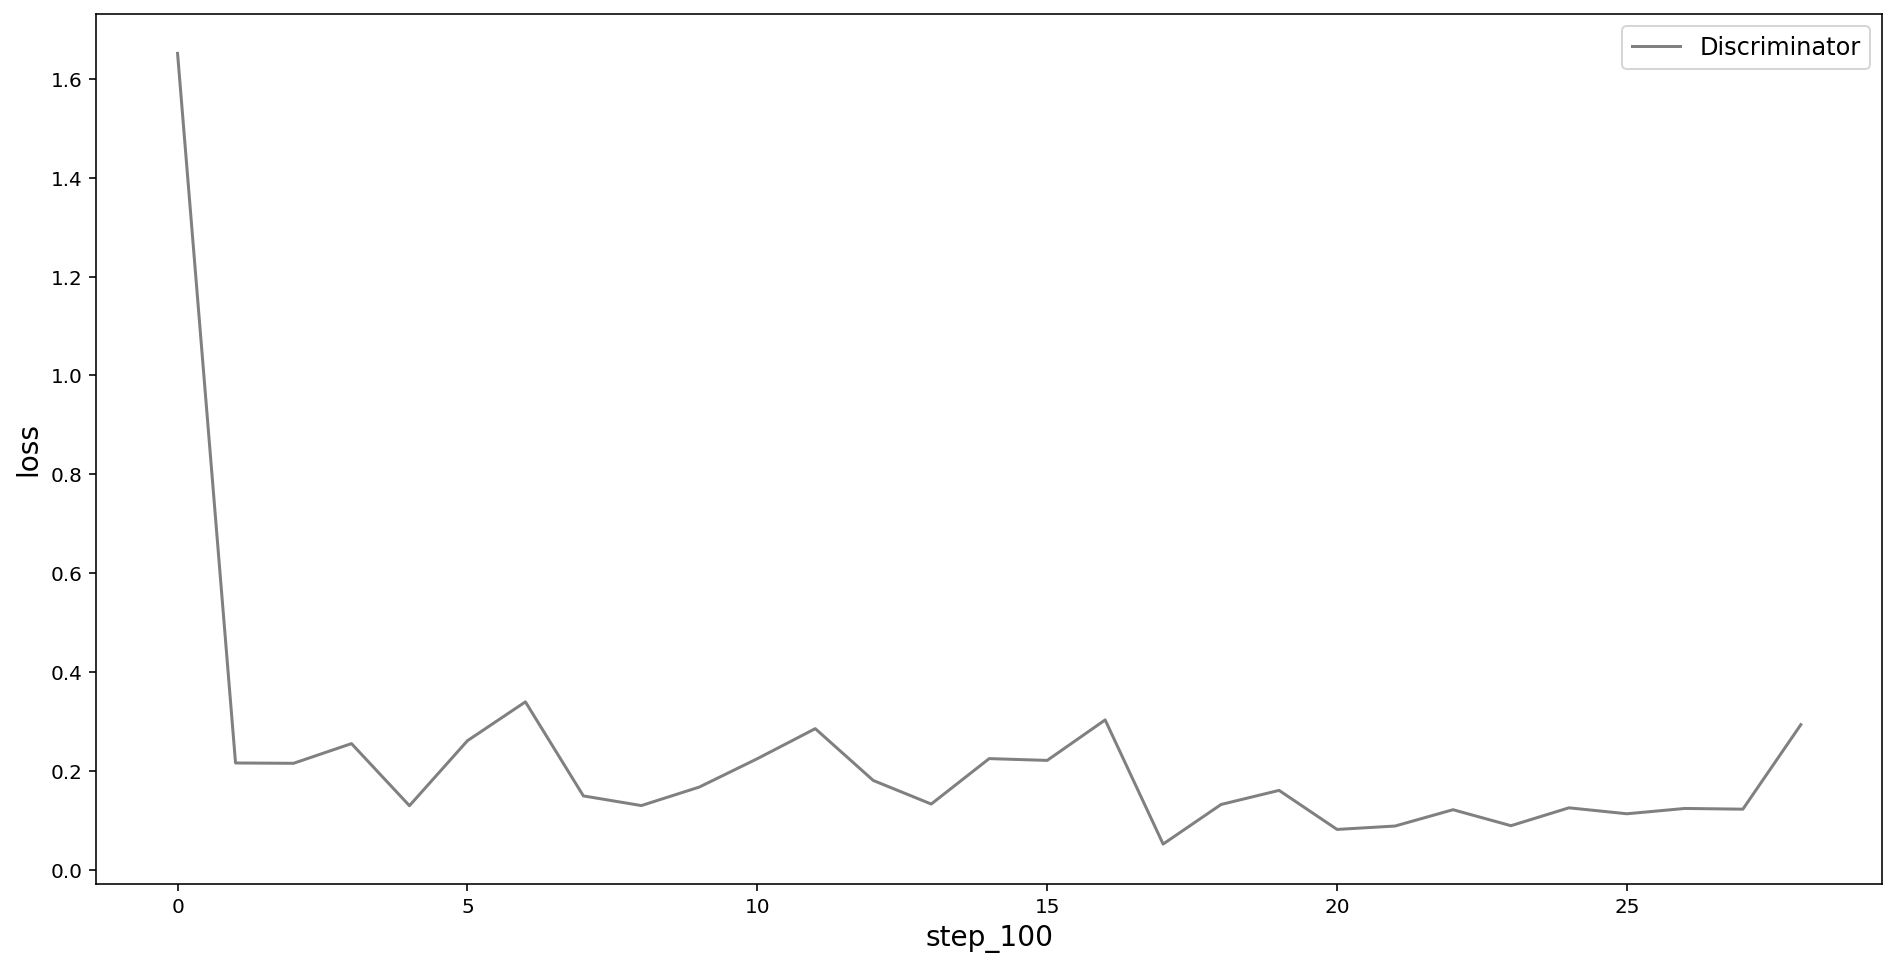

In [ ]:
# Discriminator loss 관련 시각화

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot()
ax.plot(x, loss_d_hist, color = 'gray')
plt.xlabel('step_100', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(['Discriminator'], fontsize=12, loc='best')
plt.show()

In [ ]:
print('최소 loss 값 : ' + str(loss_d_hist.min()))
print('최소 loss 값 step : ' + str(int(np.where(loss_d_hist == loss_d_hist.min())[0])))

최소 loss 값 : 0.05153341591358185
최소 loss 값 step : 17


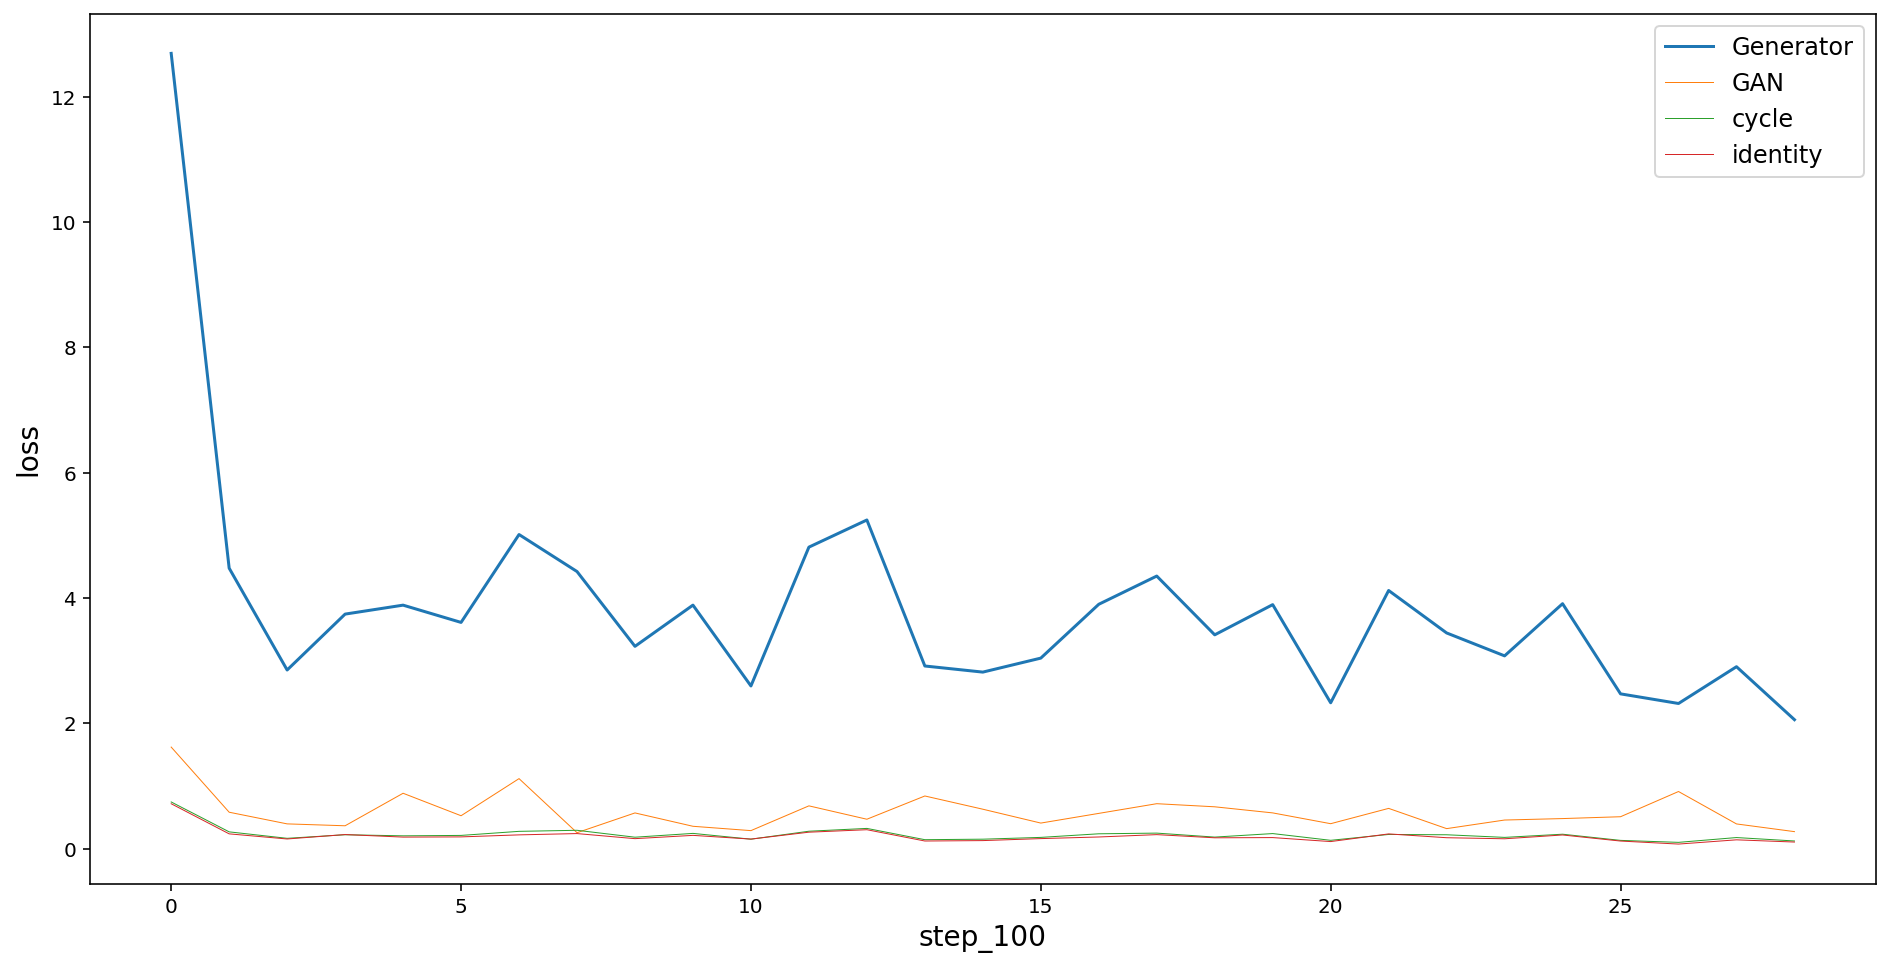

In [ ]:
# Generator loss 관련 시각화

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot()
ax.plot(x, loss_g_hist)
ax.plot(x, loss_gan_hist, linewidth = '0.5')
ax.plot(x, loss_cycle_hist, linewidth = '0.5')
ax.plot(x, loss_identity_hist, linewidth = '0.5')
plt.xlabel('step_100', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(['Generator', 'GAN', 'cycle', 'identity'], fontsize=12, loc='best')
plt.show()

In [ ]:
print('최소 loss 값 : ' + str(loss_g_hist.min()))
print('최소 loss 값 step : ' + str(int(np.where(loss_g_hist == loss_g_hist.min())[0])))

최소 loss 값 : 2.0596742630004883
최소 loss 값 step : 28
